In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style

import seaborn as sns 

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

*   using skipinitialspace to remove extra space
*   using na_value to see ? as NA


In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', skipinitialspace=True, na_values="?")
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

## Data cleaning

This section is to removed records with missing values.


In [ ]:
cleaned_df = df.copy('true').dropna(axis=0)

cleaned_df.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
8715,22,Private,204160,HS-grad,9,Divorced,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States,<=50K
1554,44,Private,139338,12th,8,Divorced,Transport-moving,Unmarried,Black,Male,0,0,40,United-States,<=50K
4451,25,Self-emp-inc,86745,Bachelors,13,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Female,0,0,40,United-States,<=50K
15779,33,Local-gov,248346,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
9273,59,Self-emp-not-inc,357943,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
10018,35,Private,171968,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
18918,46,State-gov,314770,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,48,United-States,<=50K
20948,36,Private,268292,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,41,United-States,<=50K
19635,51,Private,166934,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
26738,43,Self-emp-not-inc,147099,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,36,United-States,<=50K


In [ ]:

cleaned_df['over_50K'] = np.where(cleaned_df.income == '<=50K', 0, 1)
cleaned_df['sex_num'] = np.where(cleaned_df.sex == 'Female', 0, 1)

cleaned_df['workclass_num'] = cleaned_df.workclass.map({'Self-emp-not-inc' : 0, 'Private':1, 'State-gov':2, 
                                                          'Without-pay':3, 'Local-gov':4, 'Self-emp-inc':5, 'Federal-gov':6, 'Never-worked':7}).astype(int)


cleaned_df['marital_status_num'] = cleaned_df['marital_status'].map({'Never-married' : 0, 'Widowed' : 1, 'Separated' : 2, 
                                                                       'Married-spouse-absent' : 3, 'Married-civ-spouse' : 4, 'Divorced' : 5, 'Married-AF-spouse' : 6}).astype(int)

cleaned_df['occupation_num'] = cleaned_df['occupation'].map({'Farming-fishing' : 0, 'Other-service' : 1, 'Transport-moving' : 2, 'Protective-serv' : 3, 'Exec-managerial' : 4, 'Armed-Forces' : 5, 
 'Machine-op-inspct' : 6, 'Prof-specialty' : 7, 'Tech-support' : 8, 'Handlers-cleaners' : 9, 'Priv-house-serv' : 10, 'Adm-clerical' : 11, 'Craft-repair' : 12, 'Sales' : 13}).astype(int)

cleaned_df['relationship_num'] = cleaned_df['relationship'].map({'Wife' : 0, 'Unmarried' : 1, 'Own-child' : 2, 'Husband' : 3, 'Other-relative' : 4, 'Not-in-family' : 5}).astype(int)
cleaned_df['race_num'] = cleaned_df['race'].map({'White':0, 'Black':1, 'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3, 'Other':4})

cleaned_df.drop(columns=['fnlwgt', 'education', 'workclass', 'income', 'marital_status', 'occupation', 'sex', 'relationship', 'native_country', 'race'])

,age,education_num,capital_gain,capital_loss,hours_per_week,over_50K,sex_num,workclass_num,marital_status_num,occupation_num,relationship_num,race_num
0,50,13,0,0,13,0,1,0,4,4,3,0
1,38,9,0,0,40,0,1,1,5,9,5,0
2,53,7,0,0,40,0,1,1,4,9,3,1
3,28,13,0,0,40,0,0,1,4,7,0,1
4,37,14,0,0,40,0,0,1,4,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,12,0,0,38,0,0,1,4,8,0,0
32556,40,9,0,0,40,1,1,1,4,6,3,0
32557,58,9,0,0,40,0,0,1,1,11,1,0
32558,22,9,0,0,20,0,1,1,0,11,2,0


# Support Vector Machine

We will use the following features to train model

['education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'sex_num', 'workclass_num', 'marital_status_num', 'occupation_num', 'relationship_num', 'race_num']]

This data has two types of salary : over 50k or less than 50k

***Split data and pick features***

To understand SVM performance, dividing the dataset into a training set (80% of data) and a test set (20% of data) with train_test_split function.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pick discussed features
X = cleaned_df[['education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'sex_num', 'workclass_num', 'marital_status_num', 'occupation_num', 'relationship_num', 'race_num']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Pick the labels (Income)
Y = cleaned_df['over_50K']

# Spliting into 80% for training set and 20% for testing set
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

***Use kernelized SVM***

We use kernel trick to transform the input space to a higher dimensional space. We have the following kernels :

{‘linear : linear kernel’, ‘poly’ Polynomial Kernel, ‘rbf’ Radial Basis Function, ‘sigmoid’ Sigmoid Kernel, ‘precomputed’}, default=’rbf’

***Find the optimal hyperparamters***

Hyper-parameters are parameters that are not directly learnt within SVM. For SVC, we have 3 parameters C - kernel - gamma For more details : 

1. Kernels: The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. It is mostly useful in non-linear separation problem.

2. C (Regularisation): C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimisation how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term.

3. Gamma: It defines how far influences the calculation of plausible line of separation.

Sources :

https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

For finding the optimal hyperparameters, we'll use GridSearchCV with 2 ways of scoring : precision and recal

1. Precision attempts to answer the following question: What proportion of positive identifications was actually correct?

Precision is defined as follows: TP / (TP + FP)

2. Recall attempts to answer the following question: What proportion of actual positives was identified correctly?

Mathematically, recall is defined as follows: TP / (TP + FN)

Source : 
https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall


In [ ]:
# This code is to find the optimal hyperparameters

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def findOptimalHyperParameters():
  # Set the parameters by cross-validation
  tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 'scale'], 'C': [0.1, 1, 10, 100]},
                      {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}]

  scores = ['precision', 'recall']

  for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score, cv=3
    )

    # scaling data
    clf.fit(X_train, Y_train.ravel())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

# findOptimalHyperParameters()

***Result for finding best hyperparameter***

1. ***Tuning hyper-parameters for precision***

Best parameters set found on development set:

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.874 (+/-0.009) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.375 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.807 (+/-0.008) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.808 (+/-0.017) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.874 (+/-0.009) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.810 (+/-0.008) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.804 (+/-0.006) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.807 (+/-0.016) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.809 (+/-0.003) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.808 (+/-0.008) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.801 (+/-0.008) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.801 (+/-0.003) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.798 (+/-0.002) for {'C': 0.1, 'kernel': 'linear'}
0.797 (+/-0.002) for {'C': 1, 'kernel': 'linear'}
0.797 (+/-0.002) for {'C': 10, 'kernel': 'linear'}
0.797 (+/-0.002) for {'C': 100, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4535
           1       1.00      0.05      0.09      1498

    accuracy                           0.76      6033
   macro avg       0.88      0.52      0.48      6033
weighted avg       0.82      0.76      0.67      6033


2. ***Tuning hyper-parameters for recall***

Best parameters set found on development set:

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Grid scores on development set:

0.511 (+/-0.003) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.720 (+/-0.008) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.649 (+/-0.004) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.511 (+/-0.003) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.747 (+/-0.017) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.701 (+/-0.006) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.649 (+/-0.004) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.755 (+/-0.012) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.711 (+/-0.015) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.698 (+/-0.009) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.751 (+/-0.013) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.706 (+/-0.006) for {'C': 0.1, 'kernel': 'linear'}
0.707 (+/-0.006) for {'C': 1, 'kernel': 'linear'}
0.707 (+/-0.006) for {'C': 10, 'kernel': 'linear'}
0.707 (+/-0.006) for {'C': 100, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4535
           1       0.75      0.58      0.65      1498

    accuracy                           0.85      6033
   macro avg       0.81      0.76      0.78      6033
weighted avg       0.84      0.85      0.84      6033


                      precision    recall  f1-score   support

Income more than 50K       0.87      0.94      0.90      4535
Income less than 50K       0.75      0.58      0.65      1498

            accuracy                           0.85      6033
           macro avg       0.81      0.76      0.78      6033
        weighted avg       0.84      0.85      0.84      6033

# Learning curve and validation curve

For a better understanding, we'll draw learning curve and validation curve of svm with different hyperparameters :


1.   {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

2.   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [24]:
# this function is to show the curve
def show_curve(train_scores, test_scores, x_axis_range, title, xlabel):
  train_scores_mean= np.mean(train_scores, axis=1)
  train_scores_std= np.std(train_scores, axis=1)
  test_scores_mean= np.mean(test_scores, axis=1)
  test_scores_std= np.std(test_scores, axis=1)  
  
  
  plt.figure(figsize=(12, 12))
  plt.plot(x_axis_range, train_scores_mean, marker='o', label= "Training score")
  plt.plot(x_axis_range, test_scores_mean, marker='o', label="Cross-Validation score")

  plt.fill_between(x_axis_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color= '#33F4FF',alpha=0.5)
  plt.fill_between(x_axis_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, color= '#DDDDDD',alpha=0.5)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel('Score')
  plt.legend(loc= 'best')

***Learning curve***

Learning curve is the best tool for showing how error changes as the training set size increases. 


In [ ]:
firstModel = SVC(kernel='rbf', C = 1, gamma = 0.0001)
firstModel.fit(X_train, Y_train)

print('Data report of first model with C = 1 and gamma = 0.0001')
print(classification_report(y_test, firstModel.predict(x_test), target_names=['Income more than 50K', 'Income less than 50K']))
print()

secondModel = SVC(kernel='rbf', C = 10, gamma = 'scale')
secondModel.fit(X_train, Y_train)

print('Data report of first model with C = 10 and gamma = scale')
print(classification_report(y_test, secondModel.predict(x_test), target_names=['Income more than 50K', 'Income less than 50K']))
print()

Data report of first model with C = 1 and gamma = 0.0001
                      precision    recall  f1-score   support

Income more than 50K       0.76      1.00      0.86      4535
Income less than 50K       1.00      0.05      0.09      1498

            accuracy                           0.76      6033
           macro avg       0.88      0.52      0.48      6033
        weighted avg       0.82      0.76      0.67      6033


Data report of first model with C = 10 and gamma = scale
                      precision    recall  f1-score   support

Income more than 50K       0.87      0.94      0.90      4535
Income less than 50K       0.75      0.58      0.65      1498

            accuracy                           0.85      6033
           macro avg       0.81      0.76      0.78      6033
        weighted avg       0.84      0.85      0.84      6033




In [35]:
scoring = "accuracy"
train_size = np.linspace(0.01,20,20)

***Learning curve of 2 model***

x-axis : data set size of hold-out dataset
y-axis : performance

In [28]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

first_train_sizes, first_train_scores, first_test_scores = learning_curve(firstModel, X_train, Y_train, scoring=scoring, train_sizes=train_sizes)
second_train_sizes, second_train_scores, second_test_scores = learning_curve(secondModel, X_train, Y_train, scoring=scoring, train_sizes=train_sizes)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


learning curve for the first model with C = 1 and gamma = 0.0001


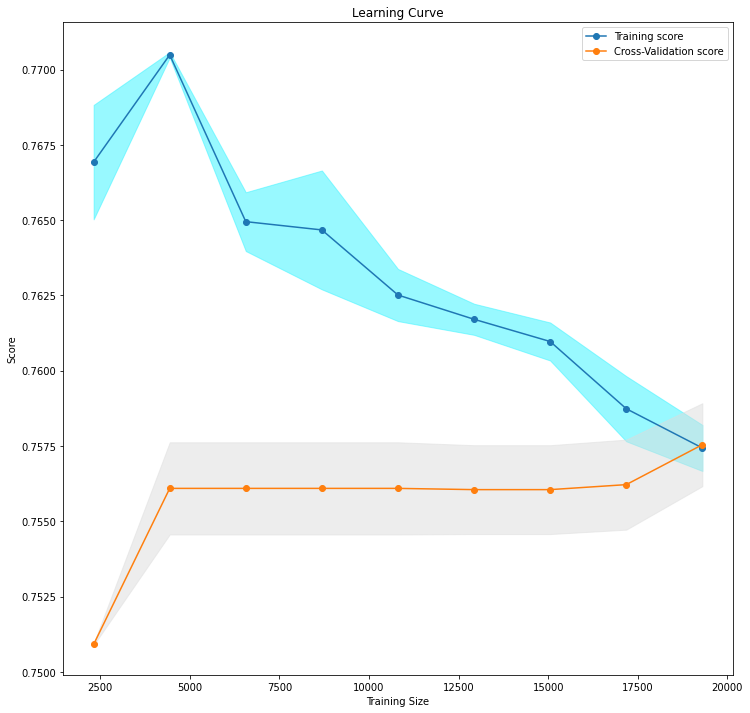

In [29]:
print('learning curve for the first model with C = 1 and gamma = 0.0001')
show_curve(first_train_scores, first_test_scores, first_train_sizes, 'Learning Curve', 'Training Size')

This is high variance

The training score reached the maximum when training size is around 3500

We can see clearly that the training score decreased while validation score  increased with more training sample.

learning curve for the second model with C = 10 and gamma = scale


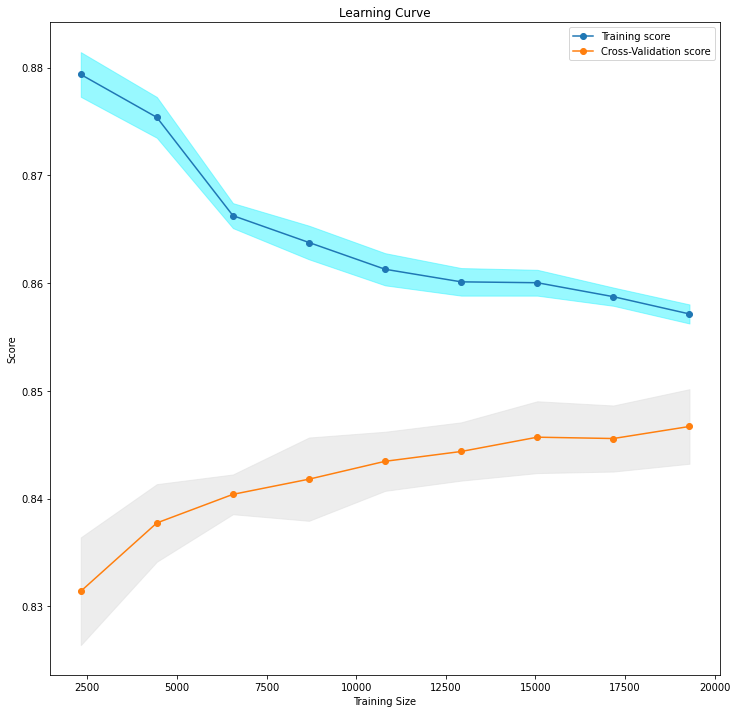

In [31]:
print('learning curve for the second model with C = 10 and gamma = scale')
show_curve(second_train_scores, second_test_scores, second_train_sizes, 'Learning Curve', 'Training Size')

This is high variance

The training score reached the maximum score when training data is 2500.
We can see clearly that the training score decreased while validation score  increased with more training sample.

***Validation curve of 2 model***

The validation curve is a tool for finding good hyper parameter settings. We'll try to evaluate parameter 'C'.

C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly.

In [37]:
from sklearn.model_selection import validation_curve

param_range = np.linspace(1,13,13)
print(param_range)
param_name= 'C'
first_validation_train_scores, first_validation_test_scores = validation_curve(firstModel, X_train, Y_train, param_name=param_name, param_range=param_range, scoring=scoring)
second_validation_train_scores, second_validation_test_scores = validation_curve(secondModel, X_train, Y_train, param_name=param_name, param_range=param_range, scoring=scoring)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


validation curve for the first model with C = 1 and gamma = 0.0001


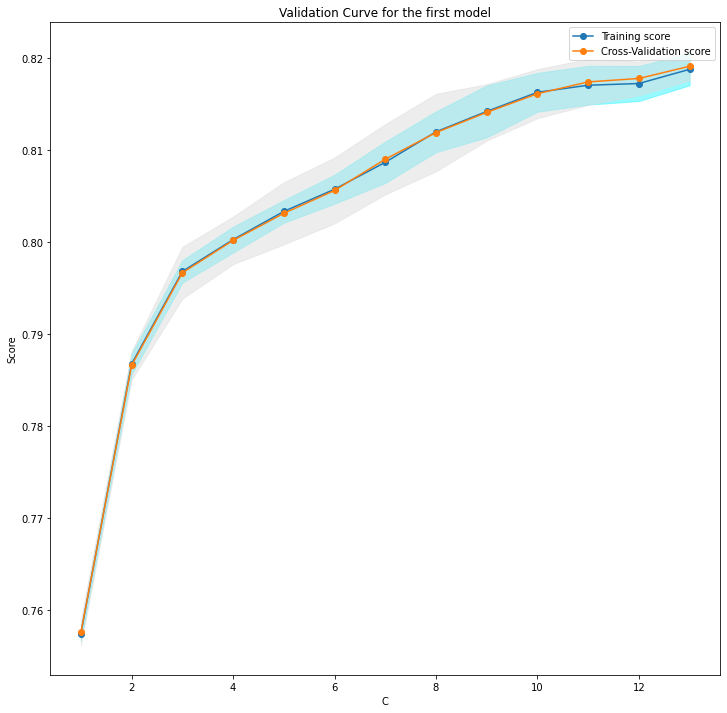

In [38]:
print('validation curve for the first model with C = 1 and gamma = 0.0001')
show_curve(first_validation_train_scores, first_validation_test_scores, param_range, 'Validation Curve for the first model', param_name)

As you can see that both training score and validation score increase when C increase.

validation curve for the second model with C = 10 and gamma = scale


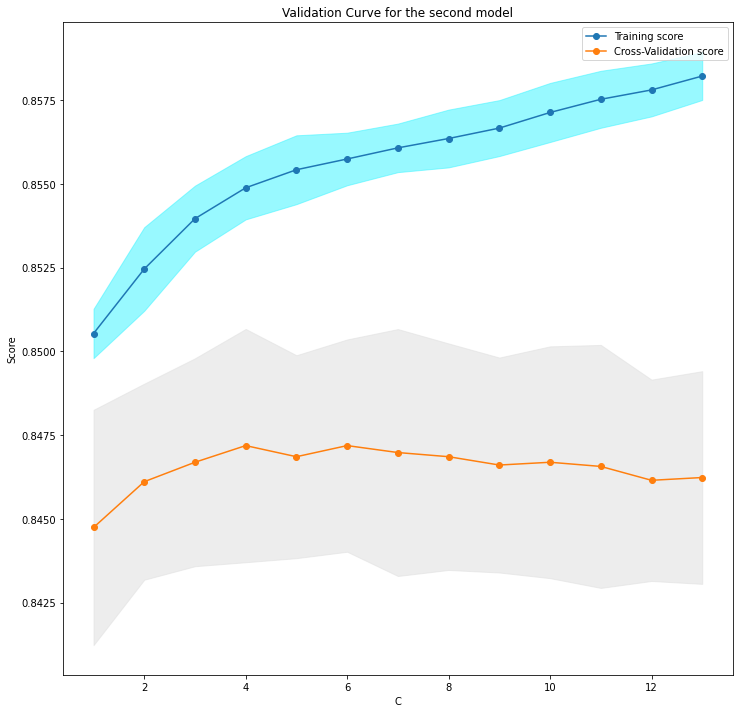

In [39]:
print('validation curve for the second model with C = 10 and gamma = scale')
show_curve(second_validation_train_scores, second_validation_test_scores, param_range, 'Validation Curve for the second model', param_name)

This is underfit when training score increased and and cross validation decreased when C increased


